## 一.从Bitly获取1.USA.gov数据

2011年，短网址服务商Bitly跟美国政府网站USA.gov合作，提供了一份以.gov或.mil结尾的短链接的用户那里收集来的匿名数据。

以每小时快照为例，文件中各行的格式为JSON（即JavaScript Object Notation，这是一种常用的Web数据格式）。例如，如果我们只读取某个文件中的第一行，那么所看到的结果应该是下面这样：

In [1]:
path = '../datasets/bitly_usagov/example.txt'
open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

Python有内置或第三方模块可以将JSON字符串转换成Python字典对象。这里，我将使用json模块及其loads函数逐行加载已经下载好的数据文件：

In [2]:
import json
path = '../datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

现在，records对象就成为一组Python字典了：

In [3]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'c': 'US',
 'nk': 1,
 'tz': 'America/New_York',
 'gr': 'MA',
 'g': 'A6qOVH',
 'h': 'wfLQtf',
 'l': 'orofrog',
 'al': 'en-US,en;q=0.8',
 'hh': '1.usa.gov',
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
 't': 1331923247,
 'hc': 1331822918,
 'cy': 'Danvers',
 'll': [42.576698, -70.954903]}

### 1.1纯python时区计数

假设我们想要知道该数据集中最常出现的是哪个时区（即tz字段），得到答案的办法有很多。首先，我们用列表推导式取出一组时区：

In [4]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

我们发现并不是所有的记录都有时区字段， 通过if判断tz字段是否在巨鹿记录里：

In [5]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

只看前10个时区，我们发现有些是未知的（即空的）。虽然可以将它们过滤掉，但现在暂时先留着。接下来，为了对时区进行计数，这里介绍两个办法：一个较难（只使用标准Python库），另一个较简单（使用pandas）。计数的办法之一是在遍历时区的过程中将计数值保存在字典中：

In [6]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

如果使用Python标准库的更高级工具，那么你可能会将代码写得更简洁一些：

In [7]:
from collections import defaultdict
def get_counts2(sequence):
    counts = defaultdict(int) # values will initialize to 0
    for x in sequence:
        counts[x] += 1
    return counts

我将逻辑写到函数中是为了获得更高的复用性。要用它对时区进行处理，只需将time_zones传入即可

In [8]:
counts = get_counts(time_zones)
counts['America/New_York']

1251

In [9]:
len(time_zones)

3440

如果想要得到前10位的时区及其计数值，我们需要用到一些有关字典的处理技巧：

In [10]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

然后有：

In [11]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

如果你搜索Python的标准库，你能找到collections.Counter类，它可以使这项工作更简单：

In [12]:
from collections import Counter
counts = Counter(time_zones)
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

### 1.2使用pandas进行时区计数

从原始记录的集合创建DateFrame，与将记录列表传递到pandas.DataFrame一样简单：

In [13]:
import pandas as pd
frame = pd.DataFrame(records)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
a              3440 non-null object
c              2919 non-null object
nk             3440 non-null float64
tz             3440 non-null object
gr             2919 non-null object
g              3440 non-null object
h              3440 non-null object
l              3440 non-null object
al             3094 non-null object
hh             3440 non-null object
r              3440 non-null object
u              3440 non-null object
t              3440 non-null float64
hc             3440 non-null float64
cy             2919 non-null object
ll             2919 non-null object
_heartbeat_    120 non-null float64
kw             93 non-null object
dtypes: float64(4), object(14)
memory usage: 500.8+ KB


In [14]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

这里frame的输出形式是摘要视图（summary view），主要用于较大的DataFrame对象。我们然后可以对Series使用value_counts方法：

In [15]:
tz_counts = frame['tz'].value_counts()
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

我们可以用matplotlib可视化这个数据。为此，我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替换缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引加以替换：

In [16]:
clean_tz = frame['tz'].fillna('Missing')
clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

此时，我们可以用seaborn包创建水平柱状图：

In [17]:
import seaborn as sns
subset = tz_counts[:10]
sns.barplot(y=subset.index, x=subset.values)

a字段含有执行网址缩短的浏览器、设备、应用程序的相关信息：

In [18]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [19]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [20]:
frame['a'][51][:50] # 前50个字符的信息

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P9'

将这些"代理"字符串中的所有信息都解析出来是一件挺郁闷的工作。一种策略是将这种字符串的第一节（与浏览器大致对应）分离出来并得到另外一份用户行为摘要：

In [21]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])
results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [22]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设你想按Windows和非Windows用户对时区统计信息进行分解。为了简单起见，我们假定只要agent字符串中含有"Windows"就认为该用户为Windows用户。由于有的agent缺失，所以首先将它们从数据中移除：

In [23]:
cframe = frame[frame.a.notnull()]

然后计算出各行是否含有Windows的值：

In [24]:
import numpy as np
cframe['os'] = np.where(cframe['a'].str.contains('Windows'),
                        'Windows', 'Not Windows')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
cframe['os'][:5]

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [26]:
by_tz_os = cframe.groupby(['tz', 'os'])

分组计数，类似于value_counts函数，可以用size来计算。并利用unstack对计数结果进行重塑：

In [27]:
agg_counts = by_tz_os.size().unstack().fillna(0)
agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，我根据agg_counts中的行数构造了一个间接索引数组：

In [28]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后我通过take按照这个顺序截取了最后10行最大值：

In [29]:
count_subset = agg_counts.take(indexer[-10:])
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas有一个简便方法nlargest，可以做同样的工作：

In [30]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

然后，如这段代码所示，可以用柱状图表示。我传递一个额外参数到seaborn的barpolt函数，来画一个堆积条形图

In [31]:
count_subset = count_subset.stack()
count_subset.name = 'total'
count_subset = count_subset.reset_index()
count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


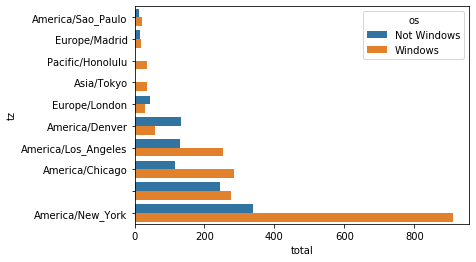

In [32]:
sns.barplot(x='total', y='tz', hue='os',  data=count_subset)

这张图不容易看出Windows用户在小分组中的相对比例，因此我们将组百分比归一化为1：

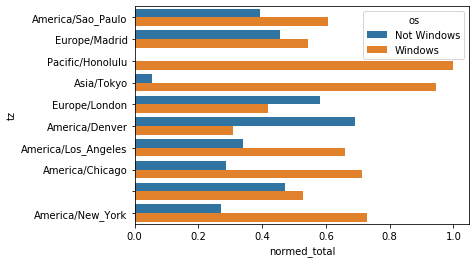

In [33]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

results = count_subset.groupby('tz').apply(norm_total)
sns.barplot(x='normed_total', y='tz', hue='os',  data=results)

我们还可以用groupby的transform方法，更高效的计算标准化的和：

In [34]:
g = count_subset.groupby('tz')
results2 = count_subset.total / g.total.transform('sum')

## 二.Movielens 1M 数据集

Movielens用户提供了一些电影评分数据的集合。这些数据包括电影的评分，电影的元数据以及观众数据(年龄，邮编，性别，职业)。在这里我将展示如何将这些数据切片成你需要的确切形式。


MovieLens 1M数据集含有来自6000名用户对4000部电影的100万条评分数据。它分为三个表：评分、用户信息和电影信息。将该数据从zip文件中解压出来之后，可以通过pandas.read_table将各个表分别读到一个pandas DataFrame对象中：

In [36]:
import pandas as pd
pd.options.display.max_rows = 10 # 让展示的内容少一点
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('../datasets/movielens/users.dat', sep='::',
                      header=None, names=unames)
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('../datasets/movielens/ratings.dat', sep='::',
                        header=None, names=rnames)
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('../datasets/movielens/movies.dat', sep='::',
                       header=None, names=mnames)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp

利用Python的切片语法，通过查看每个DataFrame的前几行即可验证数据加载工作是否一切顺利：

In [37]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [38]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [39]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


注意，其中的年龄和职业是以编码形式给出的，它们的具体含义请参考该数据集的README文件。分析散布在三个表中的数据可不是一件轻松的事情。假设我们想要根据性别和年龄计算某部电影的平均得分，如果将所有数据都合并到一个表中的话问题就简单多了。我们先用pandas的merge函数将ratings跟users合并到一起，然后再将movies也合并进去。pandas会根据列名的重叠情况推断出哪些列是合并（或连接）键：

In [42]:
data = pd.merge(pd.merge(ratings, users), movies)
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [43]:
data.iloc[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

为了按性别计算每部电影的平均得分，我们可以使用pivot_table方法：

In [44]:
mean_ratings = data.pivot_table('rating', index='title',
                                columns='gender', aggfunc='mean')
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


该操作产生了另一个DataFrame，其内容为电影平均得分，行标为电影名称（索引），列标为性别。现在，我打算过滤掉评分数据不够250条的电影（随便选的一个数字）。为了达到这个目的，我先对title进行分组，然后利用size()得到一个含有各电影分组大小的Series对象：

In [45]:
ratings_by_title = data.groupby('title').size()
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [46]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

标题索引中含有评分数据大于250条的电影名称，然后我们就可以根据mean_ratings选取所需的行了：

In [48]:
mean_ratings = mean_ratings.loc[active_titles]
mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
...,...,...
Young Guns (1988),3.371795,3.425620
Young Guns II (1990),2.934783,2.904025
Young Sherlock Holmes (1985),3.514706,3.363344


为了了解女性观众最喜欢的电影，我们可以对F列降序排列：

In [49]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


### 2.1测量评价分歧

假设我们想要找出男性和女性观众分歧最大的电影。一个办法是给mean_ratings加上一个用于存放平均得分之差的列，并对其进行排序：

In [50]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

按"diff"排序即可得到分歧最大且女性观众更喜欢的电影：

In [52]:
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:10]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


对排序结果反序并取出前10行，得到的则是男性观众更喜欢的电影：

In [55]:
sorted_by_diff[::-1][:10]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


如果只是想要找出分歧最大的电影（不考虑性别因素），则可以计算得分数据的方差或标准差：

In [56]:
rating_std_by_title = data.groupby('title')['rating'].std()
rating_std_by_title = rating_std_by_title.loc[active_titles]
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## 三.美国1880~2010年的婴儿名字

美国社会保障总署（SSA）提供了一份从1880年到现在的婴儿名字频率数据。

由于这是一个非常标准的以逗号隔开的格式，所以可以用pandas.read_csv将其加载到DataFrame中：